In [1]:
# Data Flattening
import numpy as np
import pandas as pd

import datetime
from datetime import datetime

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StringType, IntegerType, ArrayType, FloatType, MapType, LongType
from pyspark.sql.functions import lit, udf, size, avg, min as min_, max as max_, sum as sum_, count, countDistinct, col, mean, stddev, struct, explode, explode_outer, unix_timestamp, sum as sum_
from operator import itemgetter
import json

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

from pyspark.ml.feature import Bucketizer

from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql import functions as F
from pyspark.sql.functions import collect_list, collect_set, row_number, dense_rank, lead, lag, rank
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegressionModel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

import collections
from collections import deque
import redis
import json


In [2]:

env = "production"
DATE = '2020-01-2[789]/'
file_path = 's3://mist-secorapp-{env}/oc-stats-analytics/oc-stats-analytics-{env}/dt={date}/*'.format(env=env, date=DATE)
df = spark.read.parquet(file_path)
df.printSchema()


root
 |-- id: string (nullable = true)
 |-- mac: string (nullable = true)
 |-- org_id: string (nullable = true)
 |-- site_id: string (nullable = true)
 |-- when: long (nullable = true)
 |-- remote_addr: string (nullable = true)
 |-- clients: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- vlan_name: string (nullable = true)
 |    |    |-- mac: string (nullable = true)
 |    |    |-- flags: string (nullable = true)
 |    |    |-- age: integer (nullable = true)
 |    |    |-- iface_name: string (nullable = true)
 |    |    |-- vlan_id: integer (nullable = true)
 |    |    |-- ip: string (nullable = true)
 |    |    |-- hostname: string (nullable = true)
 |    |    |-- dhcpbound: integer (nullable = true)
 |    |    |-- username: string (nullable = true)
 |    |    |-- group: string (nullable = true)
 |    |    |-- auth_state: string (nullable = true)
 |    |    |-- auth_method: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- mo

In [3]:
site_id = "6f643507-d233-4fb1-98bd-e4445446270e"
switch_mac = "d0dd496c8bbd" # .replace(":", "")

In [4]:
df1 = df.filter(col("id").isin([switch_mac]))

In [5]:
df1.count()

3146

In [6]:
df1.columns

['id',
 'mac',
 'org_id',
 'site_id',
 'when',
 'remote_addr',
 'clients',
 'hostname',
 'model',
 'firmware_version',
 'interfaces',
 'config_history',
 'alarms',
 'ipv4_route',
 'lldpneighbors',
 'serial_number',
 'svistats',
 'stpbridge_protocol',
 'stpbridge_root_id',
 'stpbridge_root_cost',
 'stpbridge_root_port',
 'stpbridge_hello_time',
 'stpbridge_max_age',
 'stpbridge_forward_delay',
 'stpbridge_msg_age',
 'stpbridge_topo_chg_cnt',
 'stpbridge_last_topo_chg',
 'stpbridge_bridge_id',
 'uptime',
 'stats_delta',
 'delta',
 'deltaErrorMsg',
 'delta_interval',
 'poe_controller_module_index',
 'poe_controller_max_power',
 'poe_controller_consumption',
 'poe_controller_guardband',
 'chassis_modules',
 'chassis_routing_engines',
 'chassis_fans',
 'chassis_temperatures',
 'chassis_psus',
 'chassis_poe_controller',
 'switch_id',
 'last_config_xml',
 'last_rtt',
 'input_cloud_partition']

In [7]:
# to pandas 
import pandas as pd
# df1_i = df1.select(col("id"), col("when"), col("org_id"), col("site_id"), explode(col("interfaces")).alias("interface")).select('id','when', 'org_id', 'site_id', 'interface.*')
# df1_i.take(1)

df1_i = df1.select(col("id"), col("when"), col("org_id"), col("site_id"), explode(col("clients")).alias("client")).select('id','when', 'org_id', 'site_id', 'client.*')

df_pd = df1_i.toPandas()

df1_i.filter(col("dhcpbound")>0)

DataFrame[id: string, when: bigint, org_id: string, site_id: string, vlan_name: string, mac: string, flags: string, age: int, iface_name: string, vlan_id: int, ip: string, hostname: string, dhcpbound: int, username: string, group: string, auth_state: string, auth_method: string]

In [8]:
df_pd.head()

,id,when,org_id,site_id,vlan_name,mac,flags,age,iface_name,vlan_id,ip,hostname,dhcpbound,username,group,auth_state,auth_method
0,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,5c5b35504a2e,,0,ge-0/0/1,100,192.168.100.153,DK1-AP1,0,,,,
1,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,000bab9e2c04,,0,ge-0/0/4,100,0.0.0.0,,0,,,,
2,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,000c299f4f4c,,0,ge-0/0/4,100,0.0.0.0,,0,,,,
3,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,84248d189390,,0,ge-0/0/5,100,192.168.100.159,dk1-wired-1,0,,,,
4,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,5c5b354eb6c6,,0,ge-0/0/7,100,192.168.100.142,DK1-AP2,0,,,,


In [9]:
df_pd.columns

Index(['id', 'when', 'org_id', 'site_id', 'vlan_name', 'mac', 'flags', 'age',
       'iface_name', 'vlan_id', 'ip', 'hostname', 'dhcpbound', 'username',
       'group', 'auth_state', 'auth_method'],
      dtype='object')

In [11]:
df_pd_with_dhcp = df_pd[df_pd['dhcpbound']>0]

# df_pd[['id', 'mac', 'iface_name', 'dhcpbound']].groupby([ 'id', 'mac', 'iface_name', 'dhcpbound']).count()

df_pd[['id', 'mac', 'iface_name', 'dhcpbound']].groupby([ 'id', 'mac', 'iface_name', 'dhcpbound']).count()

Empty DataFrame
Columns: []
Index: [(d0dd496c8bbd, 000bab9e2c04, ge-0/0/4, 0), (d0dd496c8bbd, 000c299f4f4c, ge-0/0/4, 0), (d0dd496c8bbd, 5c5b354eb6c6, ge-0/0/7, 0), (d0dd496c8bbd, 5c5b35504a2e, ge-0/0/1, 0), (d0dd496c8bbd, 705ab6b4c7b0, ge-0/0/8, 0), (d0dd496c8bbd, 84248d189390, ge-0/0/5, 0), (d0dd496c8bbd, 84248d189390, ge-0/0/5, 1), (d0dd496c8bbd, 84248d189391, ge-0/0/5, 0), (d0dd496c8bbd, b4c7995cb90c, ge-0/0/10.0, 0), (d0dd496c8bbd, d007ca696340, ge-0/0/0, 0)]

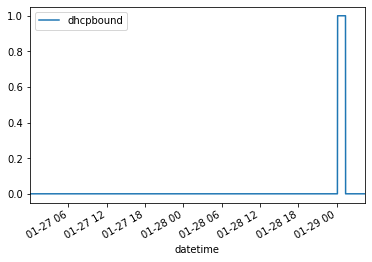

In [18]:
df_pd['datetime'] = [ pd.Timestamp(x*1000) for x in df_pd['when']]
df_pd[df_pd["mac"]=="84248d189390"].plot(x="datetime", y="dhcpbound")


In [19]:
df_pd['datetime']


0       2020-01-28 20:20:43.878155
1       2020-01-28 20:20:43.878155
2       2020-01-28 20:20:43.878155
3       2020-01-28 20:20:43.878155
4       2020-01-28 20:20:43.878155
                   ...            
25064   2020-01-27 02:59:33.397275
25065   2020-01-27 02:59:33.397275
25066   2020-01-27 02:59:33.397275
25067   2020-01-27 02:59:33.397275
25068   2020-01-27 02:59:33.397275
Name: datetime, Length: 25069, dtype: datetime64[ns]

/opt/mistsys/ds_incubator/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


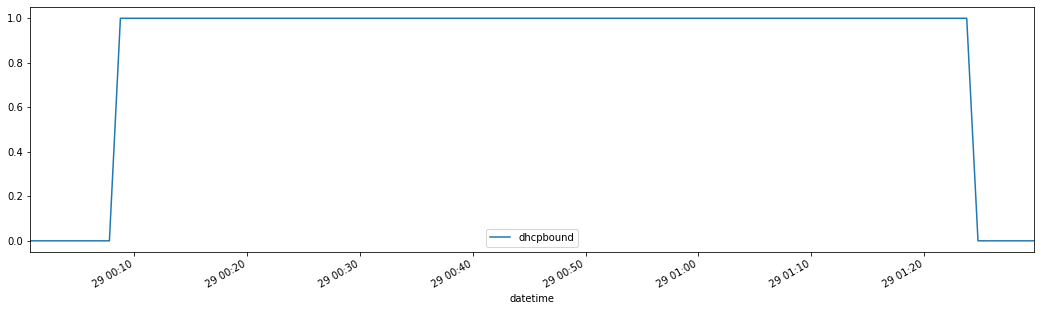

In [32]:
df_sel = df_pd[df_pd["mac"]=="84248d189390"][(df_pd['datetime']>'2020-01-29 00:0:00')&(df_pd['datetime']<'2020-01-29 01:30:00')]
df_sel.plot(x="datetime", y="dhcpbound", figsize=(18, 5))

In [27]:
# df_pd[df_pd['id']=="d0:dd:49:6c:8b:bd".replace(":", "")]

,id,when,org_id,site_id,vlan_name,mac,flags,age,iface_name,vlan_id,ip,hostname,dhcpbound,username,group,auth_state,auth_method
0,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,5c5b35504a2e,,0,ge-0/0/1,100,192.168.100.153,DK1-AP1,0,,,,
1,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,000bab9e2c04,,0,ge-0/0/4,100,0.0.0.0,,0,,,,
2,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,000c299f4f4c,,0,ge-0/0/4,100,0.0.0.0,,0,,,,
3,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,84248d189390,,0,ge-0/0/5,100,192.168.100.159,dk1-wired-1,0,,,,
4,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,5c5b354eb6c6,,0,ge-0/0/7,100,192.168.100.142,DK1-AP2,0,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22779,d0dd496c8bbd,1580093973397275,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,84248d189390,,0,ge-0/0/5,100,192.168.100.159,dk1-wired-1,0,,,,
22780,d0dd496c8bbd,1580093973397275,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,5c5b354eb6c6,,0,ge-0/0/7,100,192.168.100.142,DK1-AP2,0,,,,
22781,d0dd496c8bbd,1580093973397275,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,705ab6b4c7b0,,0,ge-0/0/8,100,0.0.0.0,,0,,,,
22782,d0dd496c8bbd,1580093973397275,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,,d007ca696340,,0,ge-0/0/0,0,69.196.157.187,DK1SRX1,0,,,,
